# OBJECTIVE: We want to create a model that predicts when an institution or idividual will default on their loan

# Table Of Contents

1. [Load Data](#Bring_Data)<br>
2. [Data Cleansing](#Data_Cleansing)<br>
    2.1 [Encoding Features](#Encoding_Features)<br>
3. [Defining our target lables](#Defining_our_target_lables)<br>
    3.1 [Features and Targets](#Features_and_Targets)<br>
4. [Scaling features and dealing with missing values](#Scaling_features)<br>
    4.1 [Scaling](#Scaling)<br>
5. [Check for correlated features](#correlated_eatures)<br>
    5.1 [Dropping correlated features](#Dropping_orrelated_eatures)<br>
6. [Saving to CSV](#Saving_to_CSV)


# Pre-Process Data Cheat Sheet
- [ ] Try opening the data in excel or something similar to see what I am dealing with before loading it into python.
- [x] Use pandas to load the data into a dataframe for easy manipulation and further examination.
- [x] When examining the data, I would look for missing values or non numerical values.
   1. The non numerical features can get converted to numerical values by using a label encoding method or a one-hot encoding method. Depending on the nature of the feature, if it is ordinal (1st, snd, Jr, Sr, g, kg, label encoding) or not and the number of unique categories I would decide what to use. With label encoding I would need to make sure that I am not assigning importance to a particular category and with one-hot encoding i would need to watch out for multicollinearity (look at vif).
   2. If the number of missing entries for a particular column is very high  in comparison with the whole data set, I would then try to drop the feature column or the rows. However, If the number of missing columns is not too high I would opt for filling in a default value and I typically tend to use the median value of that feature since it is more robust against outliers.
- [x] Lookout for outliers, you can check by plotting the data. If I found outliers:
   1. Use the standard deviation to find outliers: If a value has a distance to the average higher than 2 or 4 times the standard deviation, it can be assumed as an outlier. Or you could use Z-score (or standard score) standardizes the distance between a value and the mean using the standard deviation.
   2. Another mathematical method to detect outliers is to use percentiles. You can assume a certain percent of the value from the top or the bottom as an outlier. 
   3. Make a decision on whether to cap or drop outliers.
- [ ] Try to apply binning or Log transform if everything is possible.
- [ ] If the data looks to be transactional and you see a lot of replicated rows you could try grouping the data by instances, that way every instance is represented by one aggregated row.
- [ ] See if some of the features can be splitted. Splitting features is a good way to make them useful in terms of machine learning. Most of the time the dataset contains string columns that violates tidy data principles. By extracting the utilizable parts of a column into new features:
   1. We enable machine learning algorithms to comprehend them.
   2. Make it possible to bin and group them.
   3. Improve model performance by uncovering potential information.
- [x] Scale features:
   1. Normalization: (x-x.min)/(x.max-x.min)
   2. Standardization: (x-x.mean)/x.std
- [ ] Dealing with dates, if that feature can’t be dropped:
   1. Extracting the parts of the date into different columns: Year, month, day, etc.
   2. Extracting the time period between the current date and columns in terms of years, months, days, etc.
   3. Extracting some specific features from the date: Name of the weekday, Weekend or not, holiday or not, etc.
- [x] Remove linearly correlated features by looking at the correlation matrix form all the features to make it easier for the model to learn.


# 1. Load Data
<a id="Bring_Data"> </a>

## source:

https://www.lendingclub.com/info/download-data.action

In [1]:
import pandas as pd

In [2]:
print("Loading First Data Set")
df = pd.read_csv('https://resources.lendingclub.com/LoanStats3b.csv.zip', compression='zip', low_memory=False, skiprows=1)
# df = pd.read_csv(r"C:\Users\villeda\Documents\IpyNoteBook\Rapid_training\data\LoanStats3b.csv", low_memory=False, skiprows=1)
print("Loading Second Data Set")
df2 = pd.read_csv('https://resources.lendingclub.com/LoanStats3c.csv.zip', compression='zip', low_memory=False, skiprows=1)
# df2 = pd.read_csv(r"C:\Users\villeda\Documents\IpyNoteBook\Rapid_training\data\LoanStats3c.csv", low_memory=False, skiprows=1)
final_data = pd.concat([df,df2])

Loading First Data Set
Loading Second Data Set


In [5]:
print(final_data.shape)

(423814, 144)


This is loan information from 2012 to 2014. These data contains complete loan data for all loans issued through the time period stated, including the current loan status (Current, Late, Fully Paid, etc.) and latest payment information. We will use this data set construct a model that predicts where the loan will get paid or not.

### Lets look at the data

In [7]:
final_data.head(10)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,12000.0,12000.0,12000.0,36 months,7.62%,373.94,A,A3,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,27050.0,27050.0,27050.0,36 months,10.99%,885.46,B,B2,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,12000.0,12000.0,12000.0,36 months,10.99%,392.81,B,B2,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,4800.0,4800.0,4800.0,36 months,10.99%,157.13,B,B2,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,14000.0,14000.0,14000.0,36 months,12.85%,470.71,B,B4,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,12000.0,12000.0,12000.0,36 months,6.62%,368.45,A,A2,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,15000.0,15000.0,15000.0,36 months,8.90%,476.30,A,A5,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,7550.0,7550.0,7550.0,36 months,16.24%,266.34,C,C5,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,12000.0,12000.0,12000.0,36 months,11.99%,398.52,B,B3,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,28000.0,28000.0,28000.0,36 months,7.62%,872.52,A,A3,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 423814 entries, 0 to 235630
Columns: 144 entries, id to settlement_term
dtypes: float64(108), object(36)
memory usage: 468.8+ MB


# 2. Data Cleansing
<a id="Data_Cleansing"> </a>

There is a lot of information in this data set, including personal information that was not disclosed by the institution so it appears as N/A. Hence we need to <br>
- Remove empty and not relevant columns <br>
- Define target variable: we will use loan_status as our target variable.
- Clean empty rows.
- Scale data

In [9]:
dataset = final_data.iloc[:,2:111] 
empty_cols = [i for i in range(45,72)]   #more empty columns
dataset = dataset.drop(dataset.columns[empty_cols],axis=1)
print(f"Number of columns dropped:{len(empty_cols)}")

Number of columns dropped:27


In [10]:
dataset.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,12000.0,12000.0,12000.0,36 months,7.62%,373.94,A,A3,Systems Engineer,3 years,...,0.0,3.0,100.0,100.0,0.0,0.0,233004.0,46738.0,14800.0,53404.0
1,27050.0,27050.0,27050.0,36 months,10.99%,885.46,B,B2,Team Leadern Customer Ops & Systems,10+ years,...,0.0,1.0,100.0,25.0,0.0,0.0,138554.0,70186.0,35700.0,33054.0
2,12000.0,12000.0,12000.0,36 months,10.99%,392.81,B,B2,Project Manager,4 years,...,0.0,4.0,100.0,0.0,0.0,0.0,29700.0,7137.0,18100.0,0.0
3,4800.0,4800.0,4800.0,36 months,10.99%,157.13,B,B2,Surgical Technician,2 years,...,0.0,0.0,100.0,0.0,0.0,0.0,25700.0,4136.0,25700.0,0.0
4,14000.0,14000.0,14000.0,36 months,12.85%,470.71,B,B4,Assistant Director - Human Resources,4 years,...,0.0,0.0,78.6,100.0,1.0,0.0,31840.0,17672.0,3900.0,27340.0


In [11]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 423814 entries, 0 to 235630
Data columns (total 82 columns):
loan_amnt                         423810 non-null float64
funded_amnt                       423810 non-null float64
funded_amnt_inv                   423810 non-null float64
term                              423810 non-null object
int_rate                          423810 non-null object
installment                       423810 non-null float64
grade                             423810 non-null object
sub_grade                         423810 non-null object
emp_title                         398837 non-null object
emp_length                        403904 non-null object
home_ownership                    423810 non-null object
annual_inc                        423810 non-null float64
verification_status               423810 non-null object
issue_d                           423810 non-null object
loan_status                       423810 non-null object
pymnt_plan                   

### This is still a pretty big set of features, after cearfully looking at all of them I propse the following reduced set:

In [12]:
features = ['funded_amnt','emp_length','annual_inc','home_ownership','grade',
            "last_pymnt_amnt", "mort_acc", "pub_rec", "int_rate", "open_acc","num_actv_rev_tl",
            "mo_sin_rcnt_rev_tl_op","mo_sin_old_rev_tl_op","bc_util","bc_open_to_buy",
            "avg_cur_bal","acc_open_past_24mths",'loan_status', 'term', 'total_pymnt']
Final_data = dataset[features]

### Let change the interest rate to a float:

In [13]:
Final_data[["int_rate"]].head(5)

,int_rate
0,7.62%
1,10.99%
2,10.99%
3,10.99%
4,12.85%


# can we cast to float type right away?

In [14]:
# Final_data["int_rate"].astype(float)

In [15]:
Final_data["int_rate"] = Final_data["int_rate"].str.slice_replace(start=-1, repl='').astype(float)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html

In [16]:
Final_data.head()

,funded_amnt,emp_length,annual_inc,home_ownership,grade,last_pymnt_amnt,mort_acc,pub_rec,int_rate,open_acc,num_actv_rev_tl,mo_sin_rcnt_rev_tl_op,mo_sin_old_rev_tl_op,bc_util,bc_open_to_buy,avg_cur_bal,acc_open_past_24mths,loan_status,term,total_pymnt
0,12000.0,3 years,96500.0,MORTGAGE,A,2927.22,1.0,0.0,7.62,17.0,5.0,10.0,118.0,83.5,2441.0,11783.0,4.0,Fully Paid,36 months,13397.539998
1,27050.0,10+ years,55000.0,OWN,B,6074.19,4.0,0.0,10.99,14.0,4.0,16.0,326.0,53.9,16473.0,9570.0,3.0,Fully Paid,36 months,31752.530000
2,12000.0,4 years,60000.0,RENT,B,3775.55,0.0,0.0,10.99,15.0,7.0,1.0,48.0,15.9,15216.0,476.0,8.0,Fully Paid,36 months,13988.609996
3,4800.0,2 years,39600.0,MORTGAGE,B,3900.48,0.0,0.0,10.99,3.0,2.0,25.0,220.0,16.1,21564.0,1379.0,0.0,Fully Paid,36 months,5157.519457
4,14000.0,4 years,88000.0,RENT,B,470.47,0.0,1.0,12.85,6.0,4.0,24.0,103.0,87.7,480.0,2945.0,3.0,Fully Paid,36 months,16945.318783


### We also need to change emp_length and term to a numerical value:

In [17]:
Final_data["emp_length"] = Final_data["emp_length"].replace({'years':'','year':'',' ':'','<':'','\+':'','n/a':'0'}, regex = True).astype(float)
Final_data["term"] = Final_data["term"].replace({'years':'','year':'',' ':'','<':'','\+':'','n/a':'0','months':''}, regex = True).astype(float)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [18]:
Final_data.head()

,funded_amnt,emp_length,annual_inc,home_ownership,grade,last_pymnt_amnt,mort_acc,pub_rec,int_rate,open_acc,num_actv_rev_tl,mo_sin_rcnt_rev_tl_op,mo_sin_old_rev_tl_op,bc_util,bc_open_to_buy,avg_cur_bal,acc_open_past_24mths,loan_status,term,total_pymnt
0,12000.0,3.0,96500.0,MORTGAGE,A,2927.22,1.0,0.0,7.62,17.0,5.0,10.0,118.0,83.5,2441.0,11783.0,4.0,Fully Paid,36.0,13397.539998
1,27050.0,10.0,55000.0,OWN,B,6074.19,4.0,0.0,10.99,14.0,4.0,16.0,326.0,53.9,16473.0,9570.0,3.0,Fully Paid,36.0,31752.530000
2,12000.0,4.0,60000.0,RENT,B,3775.55,0.0,0.0,10.99,15.0,7.0,1.0,48.0,15.9,15216.0,476.0,8.0,Fully Paid,36.0,13988.609996
3,4800.0,2.0,39600.0,MORTGAGE,B,3900.48,0.0,0.0,10.99,3.0,2.0,25.0,220.0,16.1,21564.0,1379.0,0.0,Fully Paid,36.0,5157.519457
4,14000.0,4.0,88000.0,RENT,B,470.47,0.0,1.0,12.85,6.0,4.0,24.0,103.0,87.7,480.0,2945.0,3.0,Fully Paid,36.0,16945.318783


In [19]:
Final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 423814 entries, 0 to 235630
Data columns (total 20 columns):
funded_amnt              423810 non-null float64
emp_length               403904 non-null float64
annual_inc               423810 non-null float64
home_ownership           423810 non-null object
grade                    423810 non-null object
last_pymnt_amnt          423810 non-null float64
mort_acc                 416315 non-null float64
pub_rec                  423810 non-null float64
int_rate                 423810 non-null float64
open_acc                 423810 non-null float64
num_actv_rev_tl          396069 non-null float64
mo_sin_rcnt_rev_tl_op    396068 non-null float64
mo_sin_old_rev_tl_op     396068 non-null float64
bc_util                  412087 non-null float64
bc_open_to_buy           412340 non-null float64
avg_cur_bal              396057 non-null float64
acc_open_past_24mths     416315 non-null float64
loan_status              423810 non-null object
term      

In [20]:
print("Distinct Grades:", Final_data.grade.unique())
print("Distinct home_ownership:", set(Final_data.home_ownership))

Distinct Grades: ['A' 'B' 'C' 'D' 'E' 'F' 'G' nan]
Distinct home_ownership: {'MORTGAGE', nan, 'RENT', 'NONE', 'ANY', 'OWN', 'OTHER'}


# 2.1 Lable Encoding Features
<a id="Encoding_Features"> </a>
### We need to encode string values to be represented by numerical values:
- Grade = {'A':7,'B':6,'C':5,'D':4,'E':3,'F':2,'G':1}
- home_ownership = {"MORTGAGE":6,"RENT":5,"OWN":4,"OTHER":3,"NONE":2,"ANY":1}

In [24]:
Final_data['grade'] = Final_data['grade'].map({'A':7,'B':6,'C':5,'D':4,'E':3,'F':2,'G':1})
Final_data["home_ownership"] = Final_data["home_ownership"].map({"MORTGAGE":6,"RENT":5,"OWN":4,"OTHER":3,"NONE":2,"ANY":1})

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [25]:
Final_data[['grade']].head()

,grade
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN


# 3. Defining our target lables:
<a id="Defining_our_target_lables"> </a>

In [26]:
print("Distinct loan_status:", set(Final_data.loan_status))
Final_data.groupby(['loan_status'])[['annual_inc']].count()

Distinct loan_status: {nan, 'Fully Paid', 'Default', 'Late (31-120 days)', 'Charged Off'}


,annual_inc
loan_status,
Charged Off,71419
Default,1
Fully Paid,352389
Late (31-120 days),1


The only 2 significant leble asre "Fully Paid" and "Charged Off"

In [27]:
Final_data = Final_data[(Final_data['loan_status']=="Fully Paid") | (Final_data['loan_status']=="Charged Off")]

In [28]:
Final_data= Final_data.replace({"loan_status": {"Fully Paid":0, "Charged Off":1}})

In [29]:
Final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 423808 entries, 0 to 235628
Data columns (total 20 columns):
funded_amnt              423808 non-null float64
emp_length               403902 non-null float64
annual_inc               423808 non-null float64
home_ownership           0 non-null float64
grade                    0 non-null float64
last_pymnt_amnt          423808 non-null float64
mort_acc                 416313 non-null float64
pub_rec                  423808 non-null float64
int_rate                 423808 non-null float64
open_acc                 423808 non-null float64
num_actv_rev_tl          396067 non-null float64
mo_sin_rcnt_rev_tl_op    396066 non-null float64
mo_sin_old_rev_tl_op     396066 non-null float64
bc_util                  412085 non-null float64
bc_open_to_buy           412338 non-null float64
avg_cur_bal              396055 non-null float64
acc_open_past_24mths     416313 non-null float64
loan_status              423808 non-null int64
term               

# 3.1 Features and Targets:
<a id="Features_and_Targets"> </a>
Defining our target lables

In [30]:
features = set(list(Final_data.columns))
features.remove("loan_status")
features = list(features)
target = ["loan_status"]
print('features:', features)
print('target:', target)

features: ['pub_rec', 'num_actv_rev_tl', 'annual_inc', 'last_pymnt_amnt', 'mort_acc', 'home_ownership', 'bc_open_to_buy', 'int_rate', 'mo_sin_old_rev_tl_op', 'acc_open_past_24mths', 'avg_cur_bal', 'mo_sin_rcnt_rev_tl_op', 'open_acc', 'emp_length', 'grade', 'term', 'funded_amnt', 'bc_util', 'total_pymnt']
target: ['loan_status']


# 4. Scaling features and dealing with missing values
<a id="Scaling_features"> </a>

There are two ways of dealing with missing values:
- padding missing values or filling them with some kind of estimate (mean)
- dropping  rows with missing values

with this dataset we might get away with simply dropping rows with missing data.

In [31]:
# Final_data_ = Final_data.dropna()
Final_data_ = Final_data.fillna(Final_data.mean())

In [32]:
Final_data_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 423808 entries, 0 to 235628
Data columns (total 20 columns):
funded_amnt              423808 non-null float64
emp_length               423808 non-null float64
annual_inc               423808 non-null float64
home_ownership           0 non-null float64
grade                    0 non-null float64
last_pymnt_amnt          423808 non-null float64
mort_acc                 423808 non-null float64
pub_rec                  423808 non-null float64
int_rate                 423808 non-null float64
open_acc                 423808 non-null float64
num_actv_rev_tl          423808 non-null float64
mo_sin_rcnt_rev_tl_op    423808 non-null float64
mo_sin_old_rev_tl_op     423808 non-null float64
bc_util                  423808 non-null float64
bc_open_to_buy           423808 non-null float64
avg_cur_bal              423808 non-null float64
acc_open_past_24mths     423808 non-null float64
loan_status              423808 non-null int64
term               

We removed about 3000 rows.

# 4.1 Scaling
<a id="Scaling"> </a>

In [33]:
from sklearn.preprocessing import StandardScaler

The standard score of a sample x is calculated as:

z = (x - u) / s <br>

where u is the mean of the training samples or zero if with_mean=False, and s is the standard deviation of the training samples or one if with_std=False.

In [34]:
sclaer = StandardScaler() #instance of preprocessing
Final_data_[features] = pd.DataFrame(sclaer.fit_transform(Final_data_[features]), columns = features)
# data_clean['loan_status'] = Final_data['loan_status']
# data_clean['loan_status'].value_counts()

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


In [35]:
Final_data_.head()

,funded_amnt,emp_length,annual_inc,home_ownership,grade,last_pymnt_amnt,mort_acc,pub_rec,int_rate,open_acc,num_actv_rev_tl,mo_sin_rcnt_rev_tl_op,mo_sin_old_rev_tl_op,bc_util,bc_open_to_buy,avg_cur_bal,acc_open_past_24mths,loan_status,term,total_pymnt
0,-0.318088,-0.932871,0.422854,NaN,NaN,-0.235984,-0.386706,-0.322896,-1.454515,1.126385,-0.254862,-0.223797,-0.735596,0.689698,-0.452911,-0.114241,-0.071872,0,-0.618794,-0.286506
1,1.495324,1.120262,-0.346492,NaN,NaN,0.284198,1.004737,-0.322896,-0.685670,0.525987,-0.593581,0.160865,1.625301,-0.450978,0.618021,-0.255842,-0.433920,0,-0.618794,1.402592
2,-0.318088,-0.639566,-0.253799,NaN,NaN,-0.095758,-0.850521,-0.322896,-0.685670,0.726119,0.422577,-0.800791,-1.530128,-1.915358,0.522086,-0.837730,1.376322,0,-0.618794,-0.232114
3,-1.185634,-1.226175,-0.631984,NaN,NaN,-0.075108,-0.850521,-0.322896,-0.685670,-1.675472,-1.271019,0.737859,0.422152,-1.907651,1.006570,-0.779951,-1.520065,0,-0.618794,-1.044786
4,-0.077103,-0.639566,0.265278,NaN,NaN,-0.642075,-0.850521,1.567111,-0.261322,-1.075075,-0.593581,0.673748,-0.905852,0.851551,-0.602575,-0.679749,-0.433920,0,-0.618794,0.039974


# 5. Check for correlated features
<a id="correlated_features"> </a>
often you want to make inprove your model's learning time and having less inputs inproves this.

- Calculate correlation matrix
- Plot matrix

In [36]:
import matplotlib.pyplot as plt
import seaborn as sn

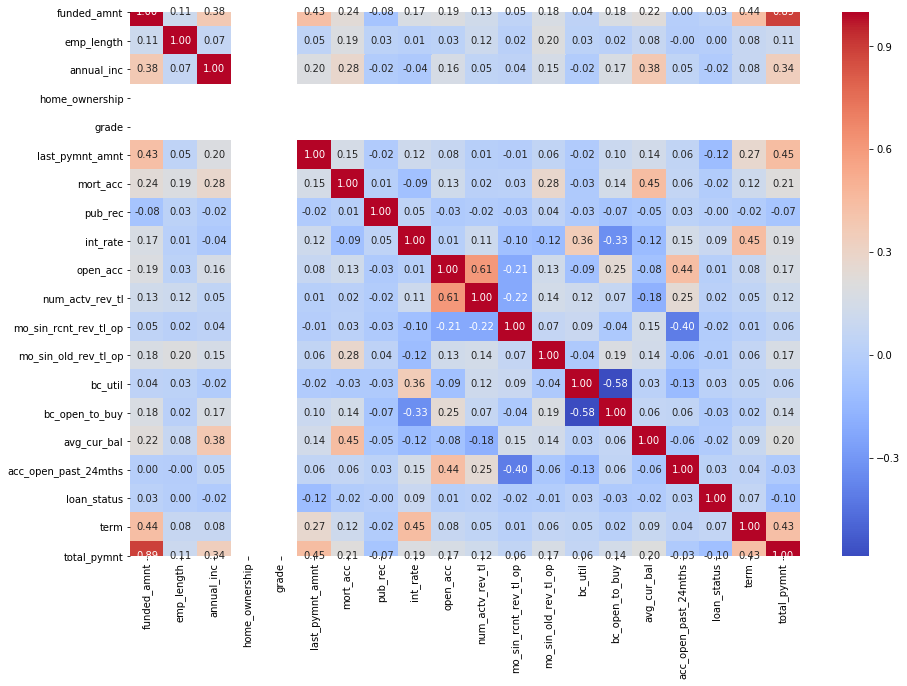

In [40]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(15,10)) 
cm_df = sn.heatmap(Final_data_.corr(),annot=True, fmt = ".2f", cmap = "coolwarm", ax=ax)

# 5.1 Dropping correlated features
<a id="Dropping_correlated_features"> </a>

In [33]:
Final_data_.drop(["total_pymnt", "num_actv_rev_tl"],axis=1, inplace=True)

In [34]:
Final_data_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 411273 entries, 0 to 235628
Data columns (total 18 columns):
funded_amnt              411273 non-null float64
emp_length               411273 non-null float64
annual_inc               411273 non-null float64
home_ownership           411273 non-null float64
grade                    411273 non-null float64
last_pymnt_amnt          411273 non-null float64
mort_acc                 411273 non-null float64
pub_rec                  411273 non-null float64
int_rate                 411273 non-null float64
open_acc                 411273 non-null float64
mo_sin_rcnt_rev_tl_op    411273 non-null float64
mo_sin_old_rev_tl_op     411273 non-null float64
bc_util                  411273 non-null float64
bc_open_to_buy           411273 non-null float64
avg_cur_bal              411273 non-null float64
acc_open_past_24mths     411273 non-null float64
loan_status              411273 non-null int64
term                     411273 non-null float64
dtypes: f

# 6. Saving to CSV
<a id="Saving_to_CSV"> </a>

In [35]:
Final_data_.to_csv("datasets_clean.csv")